<a href="https://colab.research.google.com/github/pranay2310/Credit-Card-Default-Prediction/blob/main/Credit_Card_Default_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting whether a customer will default on his/her credit card </u></b>

## <b> Problem Description </b>

### This project is aimed at predicting the case of customers default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. We can use the [K-S chart](https://www.listendata.com/2019/07/KS-Statistics-Python.html) to evaluate which customers will default on their credit card payments


## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn import preprocessing
import math
#import xlrd

In [ ]:
!pip install --upgrade xlrd

In [ ]:
import xlrd

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Almabetter/Capstone project/Credit Card Default Prediction/default_of_credit_card_clients.xls",sheet_name="Data",engine="xlrd", header=1)

In [ ]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
14972,14973,150000,2,1,2,28,0,0,-1,4,...,1182,882,441,0,1187,0,0,0,583,0
5369,5370,390000,2,2,1,44,0,0,0,0,...,180132,184420,188329,8000,8000,6500,7000,7200,5500,0
15207,15208,60000,2,1,2,27,0,0,2,2,...,8113,8971,10824,3000,1500,0,1000,2000,1000,1
23889,23890,20000,1,2,2,27,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,0
22076,22077,90000,2,2,2,28,0,0,0,0,...,37612,36174,33769,2000,1866,1347,1065,1041,1500,0


In [ ]:
#Column name 'default payment next month' is better to name it 'DEFAULT'. Shorter and without dot that could probably cause error in code.
#Column name 'PAY_0' would be better to name it 'PAY_1', to make it consistent with 'BILL_AMT1' and 'PAY_AMT1'.
df = df.rename(columns={'default payment next month': 'DEFAULT', 
                        'PAY_0': 'PAY_1'})
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.shape

(30000, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.corr()['DEFAULT']

ID          -0.013952
LIMIT_BAL   -0.153520
SEX         -0.039961
EDUCATION    0.028006
MARRIAGE    -0.024339
AGE          0.013890
PAY_1        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
BILL_AMT1   -0.019644
BILL_AMT2   -0.014193
BILL_AMT3   -0.014076
BILL_AMT4   -0.010156
BILL_AMT5   -0.006760
BILL_AMT6   -0.005372
PAY_AMT1    -0.072929
PAY_AMT2    -0.058579
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT5    -0.055124
PAY_AMT6    -0.053183
DEFAULT      1.000000
Name: DEFAULT, dtype: float64

# Univariant Analysis

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [ ]:
#Check unique value of each categorical variable
print('SEX' + str(sorted(df['SEX'].unique())))
print('EDUCATION' + str(sorted(df['EDUCATION'].unique())))
print('MARRIAGE' + str(sorted(df['MARRIAGE'].unique())))
print('PAY_1' + str(sorted(df['PAY_1'].unique())))
print('DEFAULT' + str(sorted(df['DEFAULT'].unique())))

SEX[1, 2]
EDUCATION[1, 2, 3, 4]
MARRIAGE[0, 1, 2, 3]
PAY_1[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
DEFAULT[0, 1]


##Column 1 : 'LIMIT_BAL'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


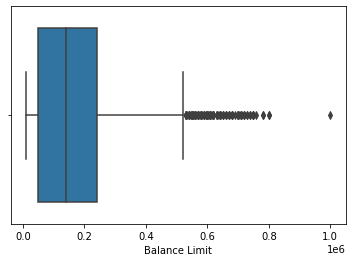

In [ ]:
sns.boxplot(df.LIMIT_BAL)
plt.xlabel('Balance Limit')
plt.show()

##Column 2: SEX

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


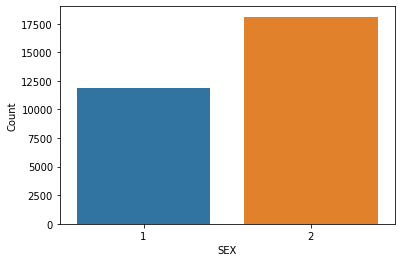

In [ ]:
sns.countplot(df.SEX)
plt.xlabel('SEX')
plt.ylabel('Count')
plt.show()

## column 3: EDUCATION

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


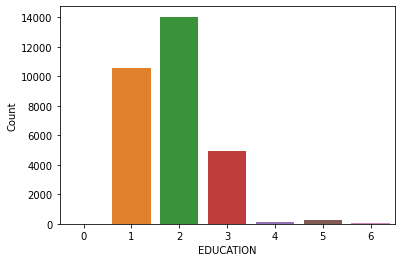

In [ ]:
sns.countplot(df.EDUCATION)
plt.xlabel('EDUCATION')
plt.ylabel('Count')
plt.show()

## Column 4: Marriage

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


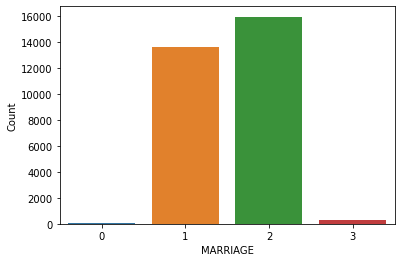

In [ ]:
sns.countplot(df.MARRIAGE)
plt.xlabel('MARRIAGE')
plt.ylabel('Count')
plt.show()

## Column 5: AGE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


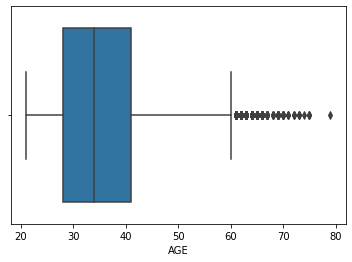

In [ ]:
#create boxplot to check probable outliers
sns.boxplot(df.AGE)
plt.xlabel('AGE')
plt.show()

## COLUMN 6 to 11:

In [ ]:
a = df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]

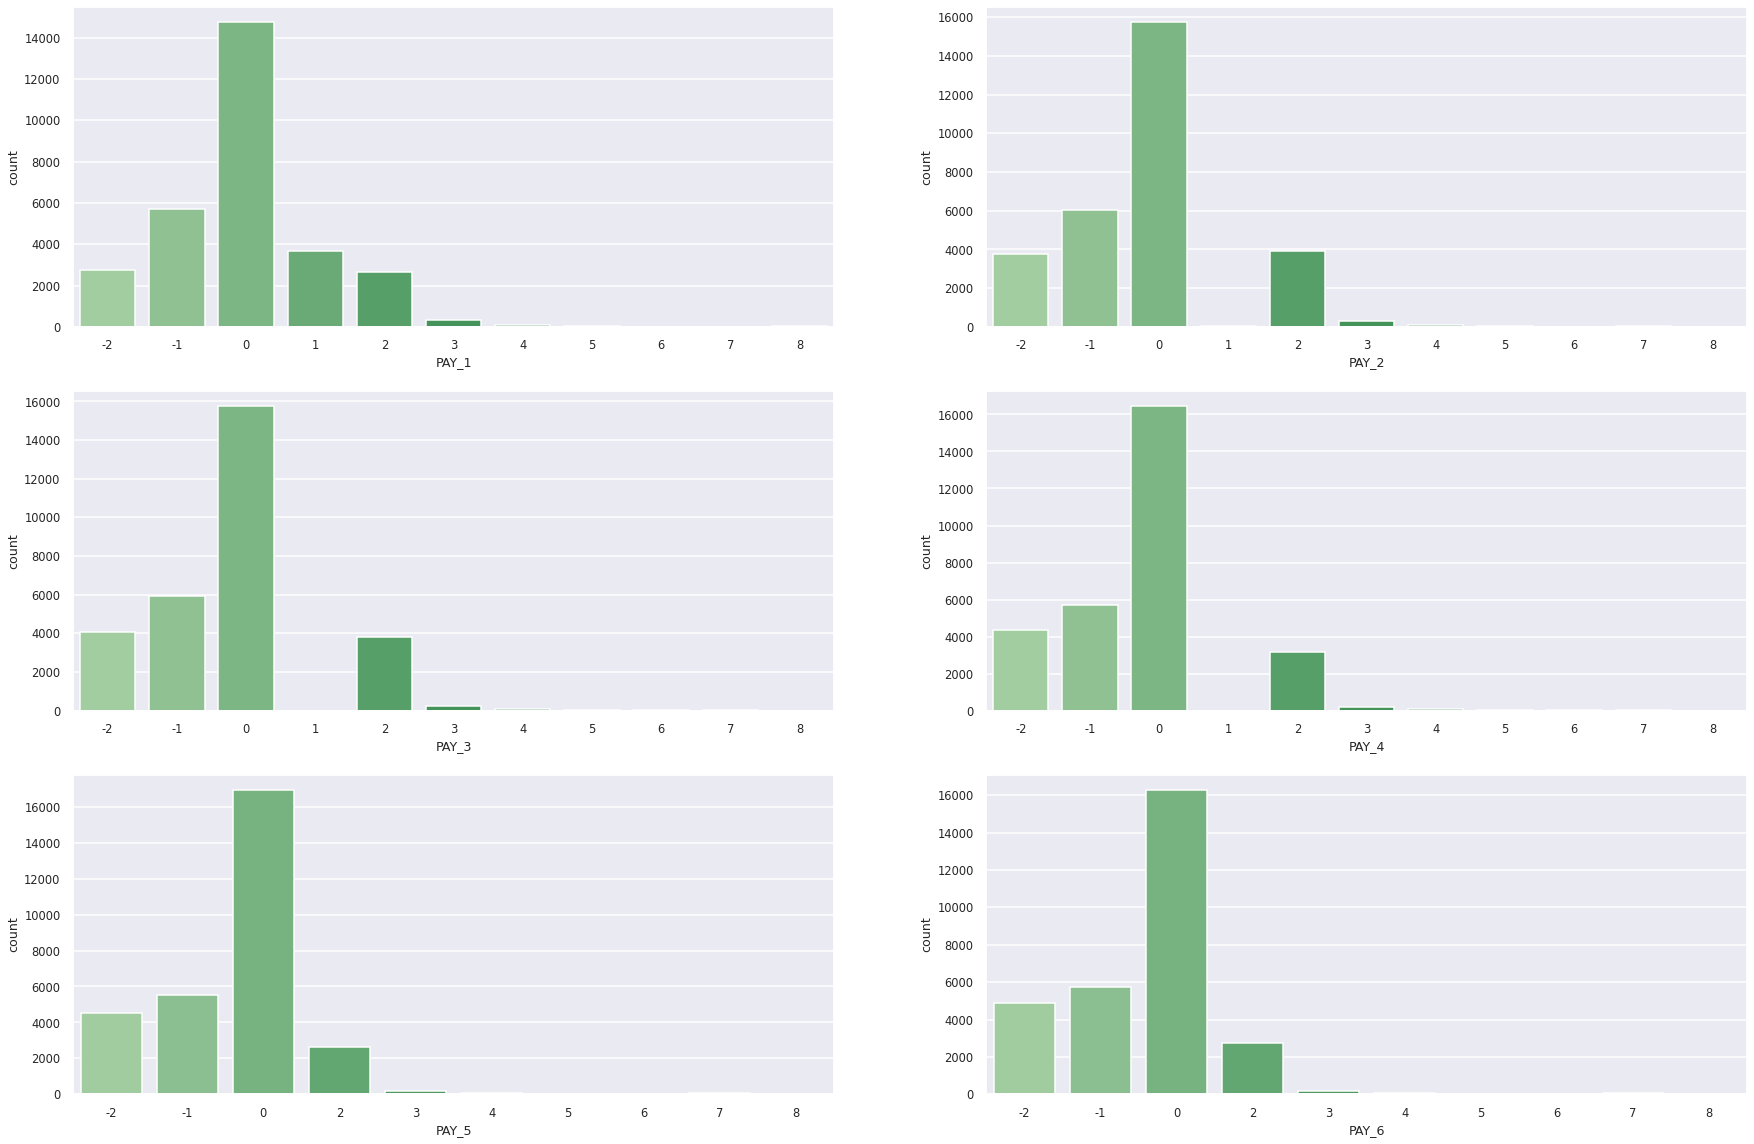

In [ ]:
# creating subplots to plot all the graphs together 
fig, axes = plt.subplots(3,2, figsize=(30, 20))
sns.countplot(ax=axes[0,0],x="PAY_1", data=a, palette="Greens_d")
              
              
sns.countplot(ax=axes[0,1],x="PAY_2", data=a, palette="Greens_d")
              

sns.countplot(ax=axes[1,0],x="PAY_3", data=a, palette="Greens_d")
            

sns.countplot(ax=axes[1,1],x="PAY_4", data=a, palette="Greens_d")

sns.countplot(ax=axes[2,0],x="PAY_5", data=a, palette="Greens_d")

sns.countplot(ax=axes[2,1],x="PAY_6", data=a, palette="Greens_d")          

In [ ]:
column 

## column 12 to 17 :

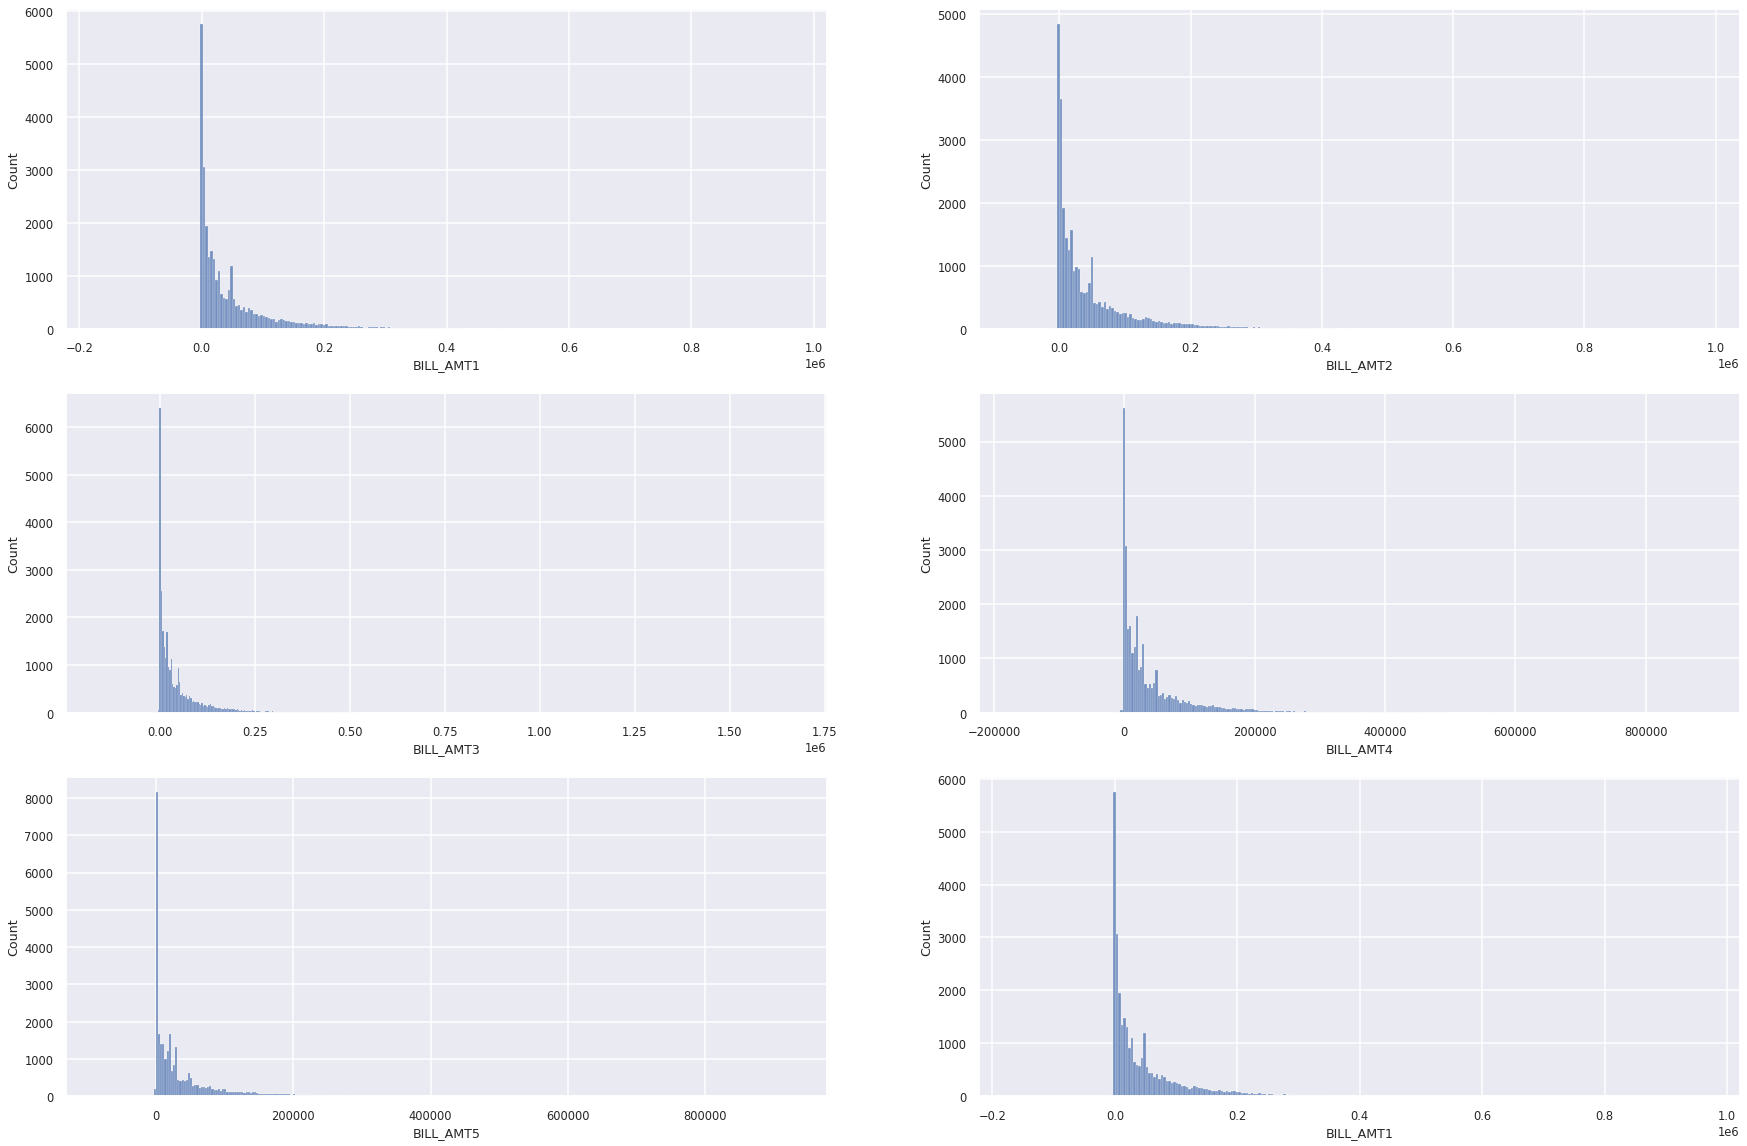

In [ ]:
# creating subplots to plot all the graphs together 
fig, axes = plt.subplots(3,2, figsize=(30, 20))
sns.histplot(ax=axes[0,0],x="BILL_AMT1", data=df)
sns.histplot(ax=axes[0,1],x="BILL_AMT2", data=df)
sns.histplot(ax=axes[1,0],x="BILL_AMT3", data=df)
sns.histplot(ax=axes[1,1],x="BILL_AMT4", data=df)
sns.histplot(ax=axes[2,0],x="BILL_AMT5", data=df)             
sns.histplot(ax=axes[2,1],x="BILL_AMT1", data=df)             


## column 18 to 23

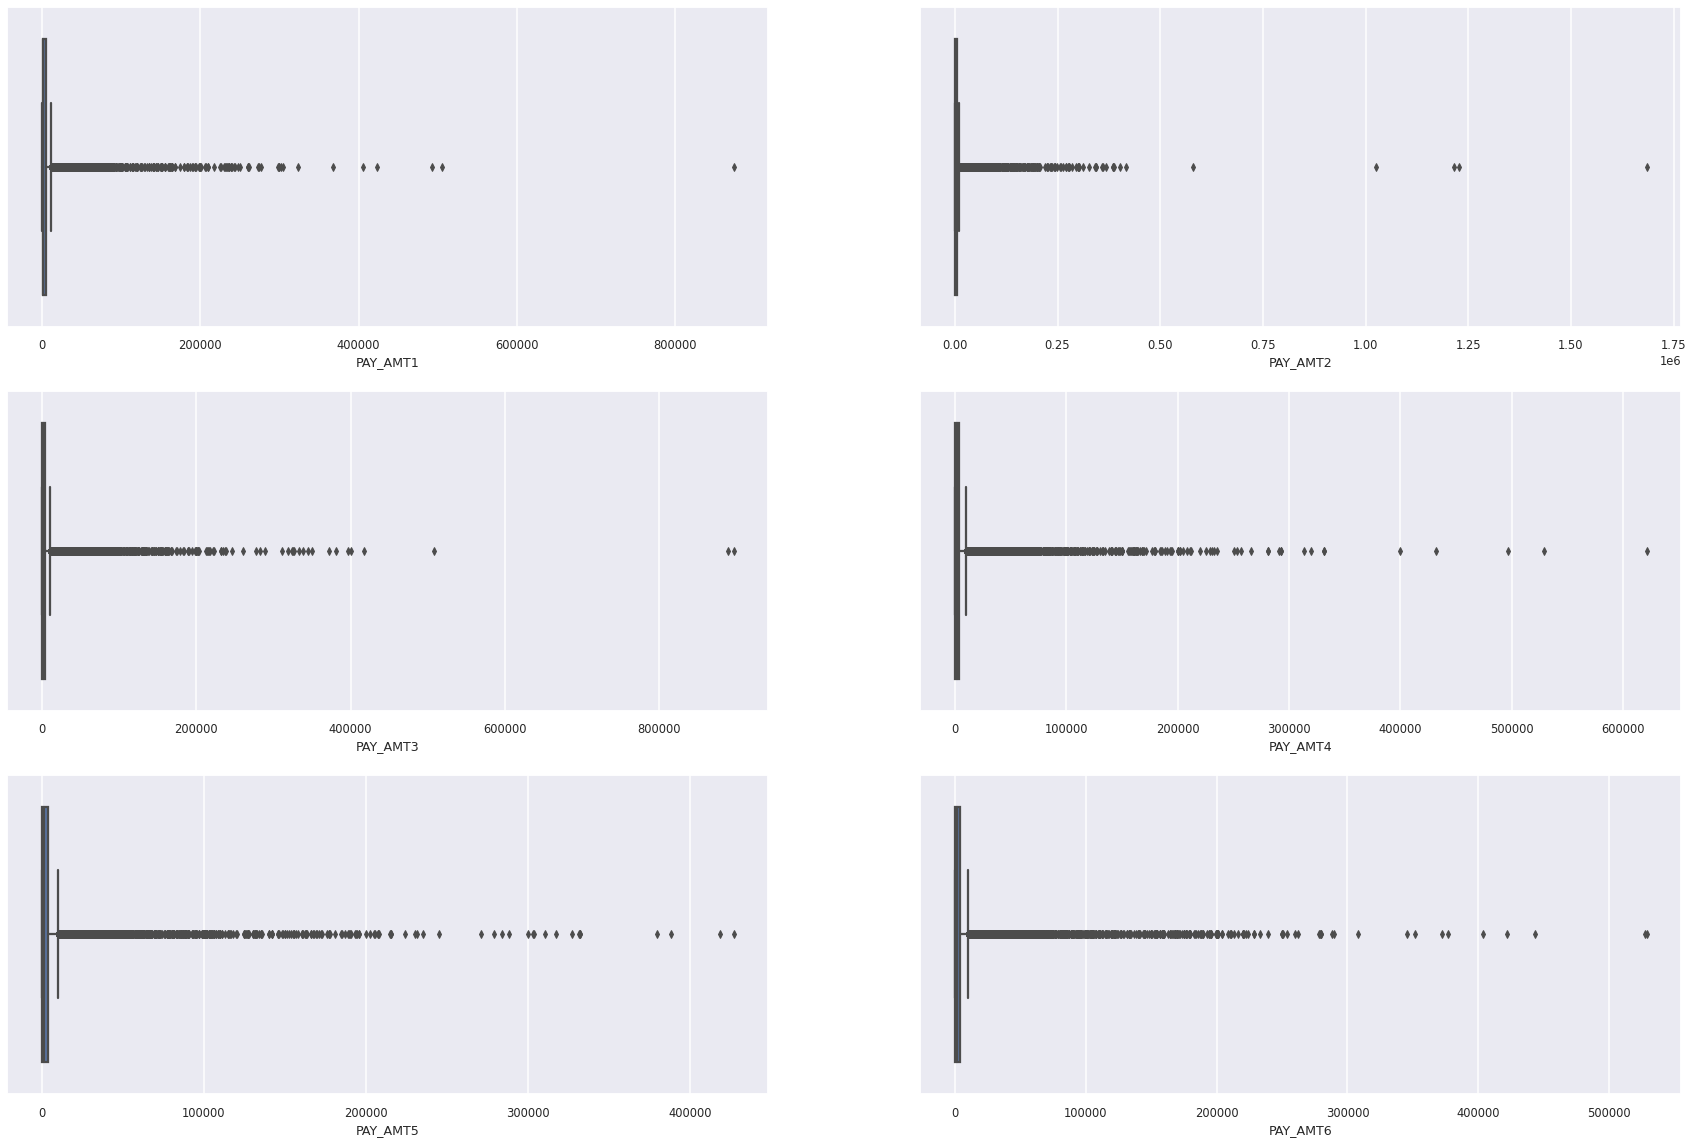

In [ ]:
# creating subplots to plot all the graphs together 
fig, axes = plt.subplots(3,2, figsize=(30, 20))
sns.boxplot(ax=axes[0,0],x="PAY_AMT1", data=df)
sns.boxplot(ax=axes[0,1],x="PAY_AMT2", data=df)
sns.boxplot(ax=axes[1,0],x="PAY_AMT3", data=df)
sns.boxplot(ax=axes[1,1],x="PAY_AMT4", data=df)
sns.boxplot(ax=axes[2,0],x="PAY_AMT5", data=df)             
sns.boxplot(ax=axes[2,1],x="PAY_AMT6", data=df)             


## column 24: DEFAULT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


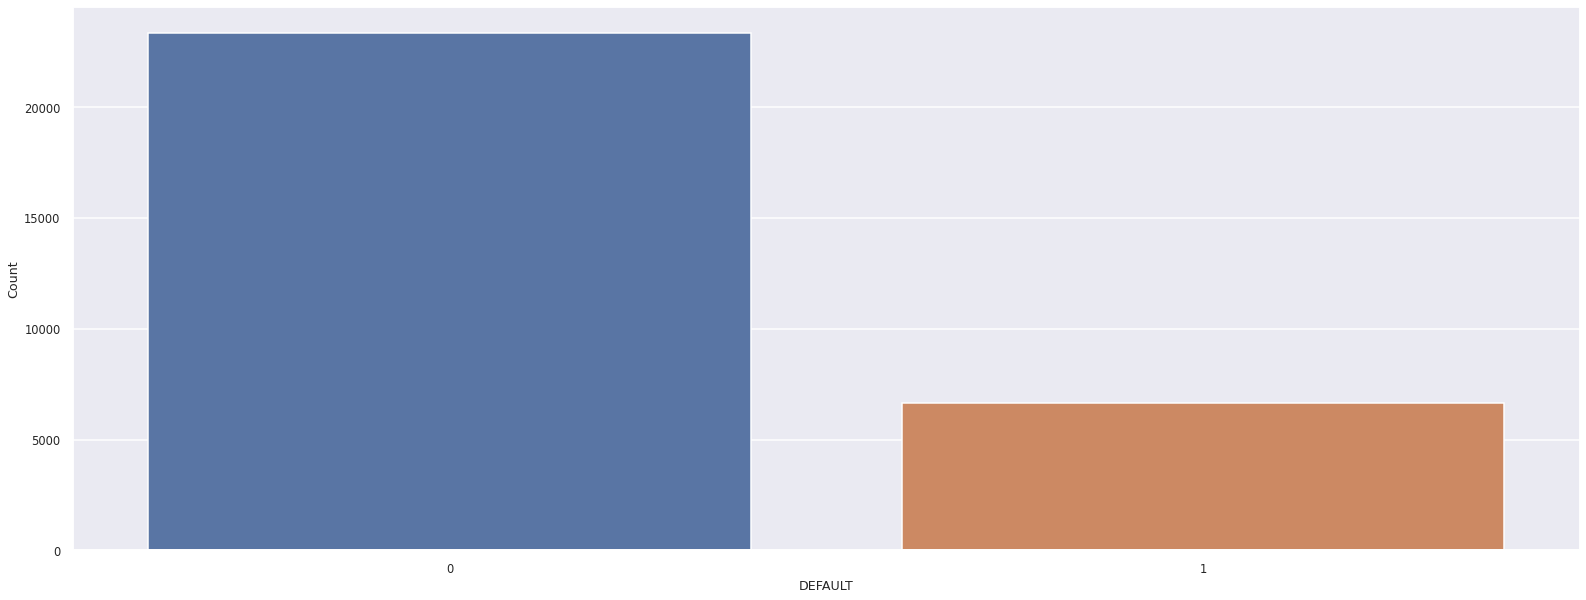

In [ ]:
sns.countplot(df.DEFAULT)
plt.xlabel('DEFAULT')
plt.ylabel('Count')
plt.show()

# Data Cleaning

In [ ]:
#Value in EDUCATION not define completely. Since 0, 4, 5, 6 all being define as other (or unknown), will be better to group them together and name it 4.
fill = (df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6)
df.loc[fill, 'EDUCATION'] = 4

print('EDUCATION ' + str(sorted(df['EDUCATION'].unique())))

EDUCATION [1, 2, 3, 4]


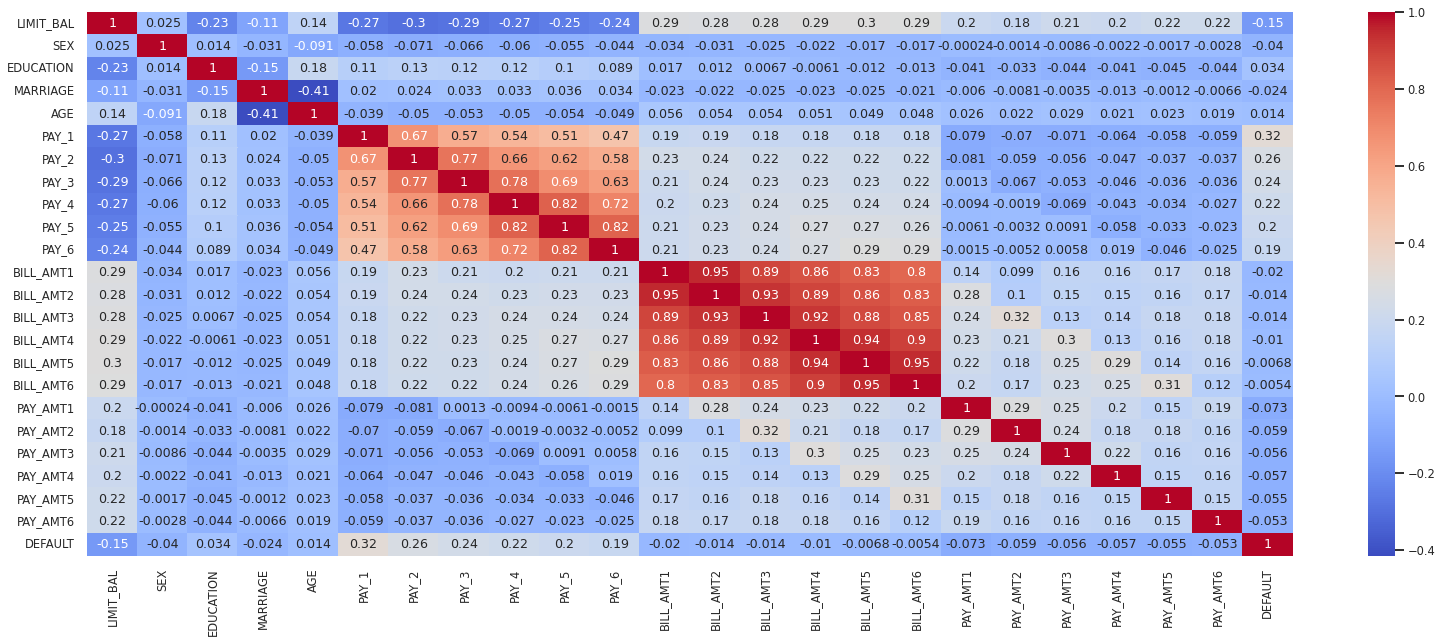

In [ ]:
sns.set(rc={'figure.figsize':(27,10)})
sns.set_context("talk", font_scale=0.7)
    
sns.heatmap(df.iloc[:,1:].corr(), cmap='coolwarm', annot=True);


## visualizing categorical Data

### Education vs. Default

In [ ]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

edu = sns.countplot(x='EDUCATION', hue='DEFAULT', data=df)
edu.set_xticklabels(['Graduate School','University','High School','Other'])
plt.show()


# Education level and Default Count

In [ ]:
default0 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['EDUCATION'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('EDUCATION').size().reset_index(name='TOTAL')

eduTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
eduTable['EDUCATION'] = ['Graduate School','University','High School','Other']

eduTable

### Default Count into Percentage

In [ ]:
eduTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
eduTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

eduPct = eduTable.iloc[:,0:3]
eduPct = eduPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

eduPct

In [ ]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = eduPct.plot(x='EDUCATION', kind='barh', stacked=True, title='Education Level vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for High School is lower than Graduate School & University. But in terms of Default Percentage, those with High School level have higher chance of Default.

# Marriage vs. Default

In [ ]:
sns.set(rc={'figure.figsize':(9,7)})
sns.set_context("talk", font_scale=0.8)

marri = sns.countplot(x="MARRIAGE", hue='DEFAULT', data=df )
marri.set_xticklabels(['Others','Married','Single','Divorce'])
plt.show()

In [ ]:
default0 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['MARRIAGE'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('MARRIAGE').size().reset_index(name='TOTAL')

marriTable = default0.join(default1['DEFAULT']).join(total['TOTAL'])
marriTable['MARRIAGE'] = ['Others','Married','Single','Divorce']

marriTable

In [ ]:
marriTable['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
marriTable['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

marriPct = marriTable.iloc[:,0:3]
marriPct = marriPct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

marriPct

In [ ]:
sns.set(rc={'figure.figsize':(9,4)})
sns.set_context("talk", font_scale=0.8)

ax = marriPct.plot(x='MARRIAGE', kind='barh', stacked=True, title='Marital Status vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Although the Default Count for Divorce is way lower than Single & Married. But in terms of Default Percentage, those who Divorce have higher chance of Default.

# Explore Credit Behaviour

Now we explore PAY_1. As information in the heatmap, PAY_1 is the higest positive correlated variable.

PAY_1: Repayment status in September, 2005 (most recent month)

(-2 = No consumption, -1 = paid in full, 0 = use of revolving credit (paid minimum only), 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above)

In [ ]:
sns.set(rc={'figure.figsize':(15,7)})
sns.set_context("talk", font_scale=0.8)

pay1 = sns.countplot(y="PAY_1", hue='DEFAULT', data=df)
pay1.set_yticklabels(['No Consumption','Paid in Full','Use Revolving Credit','Delay 1 mth','Delay 2 mths'
                     ,'Delay 3 mths','Delay 4 mths','Delay 5 mths','Delay 6 mths','Delay 7 mths','Delay 8 mths'])
pay1.set_title('Credit Behaviour (most recent month)')

plt.show()

In [ ]:
default0 = df.groupby(df['PAY_1'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default1 = df.groupby(df['PAY_1'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
total = df.groupby('PAY_1').size().reset_index(name='TOTAL')

pay1Table = default0.join(default1['DEFAULT']).join(total['TOTAL'])
pay1Table['PAY_1'] = ['No Consumption','Paid in Full','Use Revolving Credit','Delay 1 mth','Delay 2 mths'
                     ,'Delay 3 mths','Delay 4 mths','Delay 5 mths','Delay 6 mths','Delay 7 mths','Delay 8 mths']

pay1Table

In [ ]:
pay1Table['NOT_DEFAULT'] = round((default0['NOT_DEFAULT']/total['TOTAL'])*100,2)
pay1Table['DEFAULT'] = round((default1['DEFAULT']/total['TOTAL'])*100,2)

pay1Pct = pay1Table.iloc[:,0:3]
pay1Pct = pay1Pct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

pay1Pct

In [ ]:
sns.set(rc={'figure.figsize':(9,5)})
sns.set_context("talk", font_scale=0.8)

ax = pay1Pct.sort_index(ascending=False).plot(x='PAY_1', kind='barh', stacked=True, title='Credit Behaviour vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.9))
plt.show()

Credit Behaviour vs. Default
1. Those Using Revolving Credit (paid only minimum) and those delayed for 2 months have the highest Default Count.
2. When payment is delayed more than 2 months, the chances of default goes higher than 50%.

# Explore Age vs. Default

In [ ]:
df['AGE'].describe()

In [ ]:
sns.distplot(df['AGE'], norm_hist=False, kde=False);

Youngest client is 21 years old, and oldest is 79.
Most client is age range from 26 to 35.
With some specific age group having extra high number of people.

## Compare All Client vs. Defaulted Client

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.set_title('All Client', fontsize=14)
ax2.set_title('Defaulted Client', fontsize=14)

sns.distplot(df['AGE'], norm_hist=False, kde=False, ax=ax1);
sns.distplot(df['AGE'][df['DEFAULT'] == 1], norm_hist=True, kde=False, ax=ax2);

In [ ]:
default0 = df.groupby(df['AGE'][df['DEFAULT'] == 0]).size().reset_index(name='NOT_DEFAULT')
default0 = default0.fillna(0)
default1 = df.groupby(df['AGE'][df['DEFAULT'] == 1]).size().reset_index(name='DEFAULT')
default1 = default1.fillna(0)
total = df.groupby('AGE').size().reset_index(name='TOTAL')

ageTable = total.join(default0.set_index('AGE'),on='AGE').join(default1.set_index('AGE'),on='AGE')
ageTable = ageTable[['AGE', 'NOT_DEFAULT', 'DEFAULT', 'TOTAL']]
ageTable = ageTable.fillna(0)
ageTable

In [ ]:
ageTable['NOT_DEFAULT'] = round((ageTable['NOT_DEFAULT']/ageTable['TOTAL'])*100,2)
ageTable['DEFAULT'] = round((ageTable['DEFAULT']/ageTable['TOTAL'])*100,2)

agePct = ageTable.iloc[:,0:3]
agePct = agePct.rename(columns={'NOT_DEFAULT': 'NOT_DEFAULT(%)', 'DEFAULT': 'DEFAULT(%)'})

agePct

In [ ]:
sns.set(rc={'figure.figsize':(9,10)})
sns.set_context("talk", font_scale=0.5)

ax = agePct.sort_index(ascending=False).plot(x='AGE', kind='barh', stacked=True, title='Age vs. Default')
ax.set_xlabel('PERCENT')
ax.get_legend().set_bbox_to_anchor((1, 0.98))
plt.show()

For each age group > 60, we only have few data. So the percentage may not be reliable.
Take a close look at age range from 26 to 35, they have comparative lower default rate. This is also supported by large amount of data.

# Error in Dataset

There are some contradicting data in the dataset. It could be error when building up the data, or incomplete definition and explanation. Althought there is additional information in discussion, still couldn't explain all.


1.   One of the contradicting information is those who Paid in Full in recent month, turn out to be default
2.   Some client paid more than they should be, resulting a Negative Bill Amount. But still end up being default.
3.   Some client Bill Amount is much higher than their Credit Limit provided, which seldom happen in real case.



In [ ]:
error1 = df.query('BILL_AMT1 < 0 and DEFAULT == 1').loc[:,('ID','BILL_AMT1','DEFAULT')]
error1.sample(5)

In [ ]:
error2 = df.query('BILL_AMT1 > LIMIT_BAL').loc[:,('ID','LIMIT_BAL','BILL_AMT1')]
error2.sample(5)

# logistic Regression